In [1]:
from datasets import load_dataset,load_dataset_builder
import torch
import torchvision.transforms.functional as TF
from miniai.datasets import *

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)


bs = 256
@inplace
def transformi(b): b['image'] = [(torch.flatten(TF.to_tensor(o)).view(-1, 28, 28) - 0.29) / 0.35 for o in b['image']]

tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

x_mean = xb.mean((1,2,3), keepdim=True)
x_std = xb.std((1,2,3), keepdim=True)


Found cached dataset fashion_mnist (/home/admin/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
xb.mean(), xb.std()

(tensor(-0.0133), tensor(1.0032))

In [3]:
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
from miniai.init import GeneralRelu


def conv(ni, nf, ks=3, stride=2, act=True, norm=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if norm: res = nn.Sequential(res, nn.BatchNorm2d(nf))
    if act: res = nn.Sequential(res, GeneralRelu())
    return res

def get_model():
    layers = [conv(1,8),            #14x14
    conv(8,16),            #7x7
    conv(16,32),           #4x4
    conv(32,64),           #2x2
    conv(64,10, act=False, norm=False), #1x1
    nn.Flatten()]
    model = nn.Sequential(*layers)
    return model

In [22]:
class SGD(torch.optim.Optimizer):
    def __init__(self, parameters, lr=0.01, wd=0.001):
        self.parameters = list(parameters)
        self.lr, self.wd = lr, wd
        self.i = 0
    def zero_grad(self):
        for p in self.parameters: p.grad = None
    
    def reguralizer(self):
        if self.wd > 0.:
            for p in self.parameters: p.data *= (1. - self.lr * self.wd)
    
    def update_weight(self):
        for p in self.parameters: p.data -= self.lr * p.grad
    
    def step(self):
        with torch.no_grad():
            self.reguralizer()
            self.update_weight()
        self.i += 1

In [5]:
# import miniai
# from miniai.learner import MomentumLearner as Learner, DeviceCB, MetricsCB, ProgressCB, LRFinderCB
# import torch.nn.functional as F
# from torcheval.metrics import MulticlassAccuracy,Mean

# cbs = [DeviceCB(), LRFinderCB(gamma=1.1)]
# learn = Learner(get_model(), dls, F.cross_entropy, opt_func=SGD, lr=1e-4, cbs=cbs)
# learn.lr_find()

accuracy,loss,epoch,train
0.819,0.496,0,train
0.850,0.420,0,eval
0.879,0.329,1,train
0.869,0.353,1,eval
0.893,0.291,2,train
0.859,0.369,2,eval


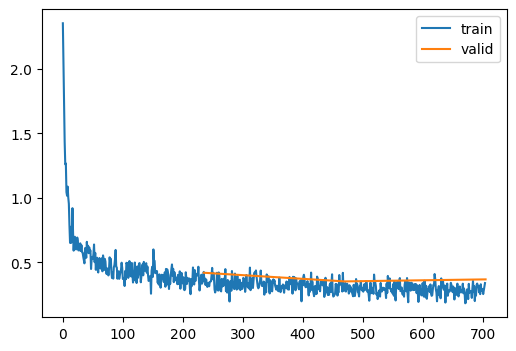

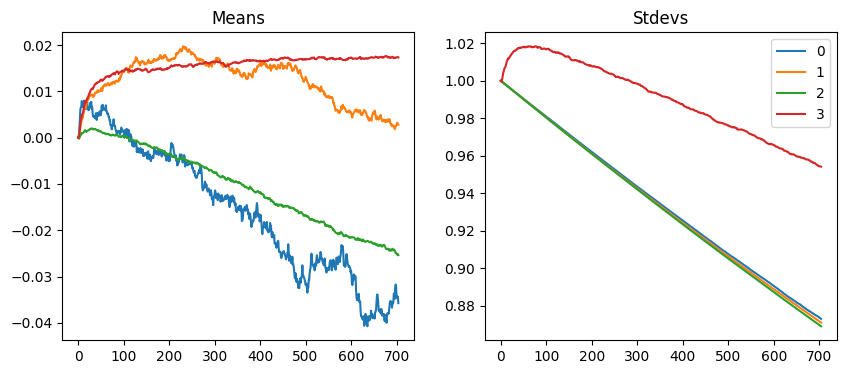

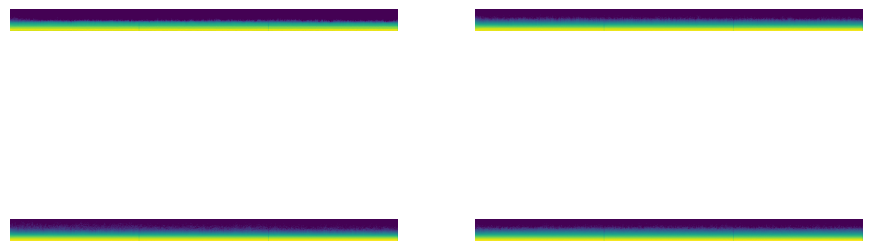

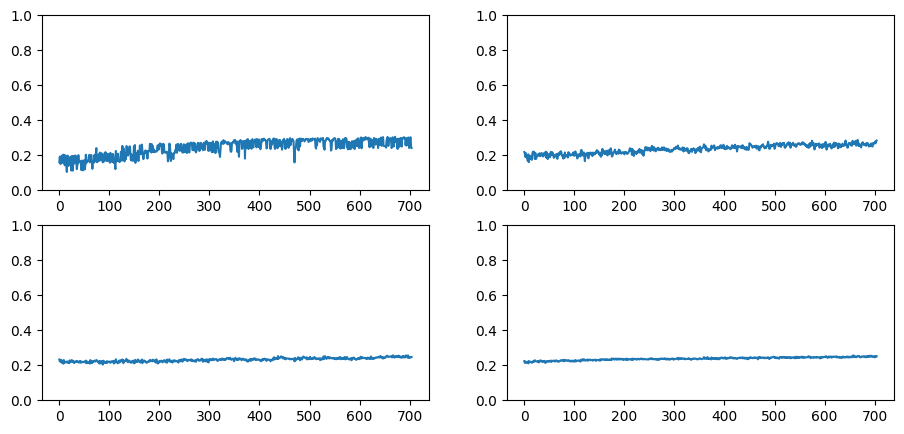

In [6]:
from miniai.activations import ActivationStats, MetricsCB, DeviceCB, ProgressCB
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from miniai.learner import TrainLearner as Learner

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
learn = Learner(get_model(), dls, F.cross_entropy, opt_func=SGD, lr=0.2,cbs=cbs)
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

accuracy,loss,epoch,train
0.913,0.241,0,train
0.892,0.287,0,eval
0.917,0.229,1,train
0.894,0.282,1,eval


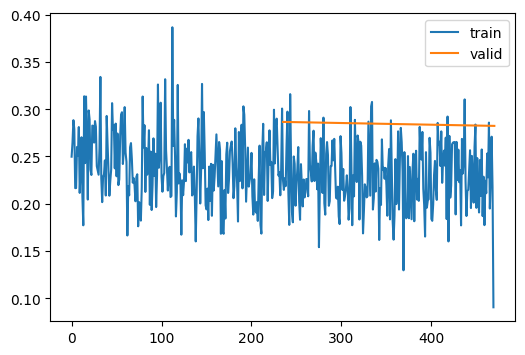

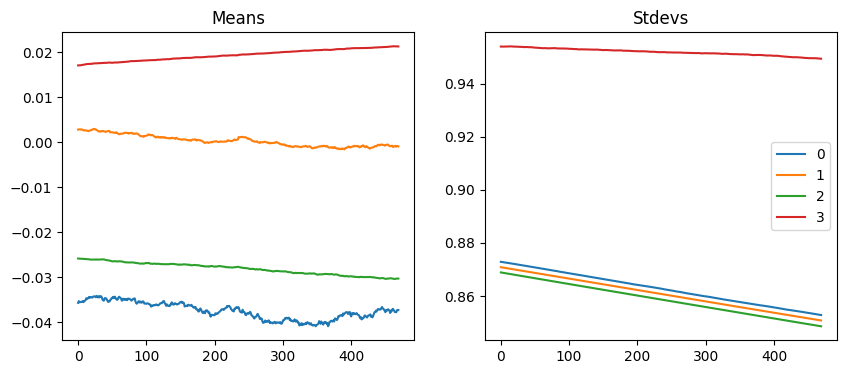

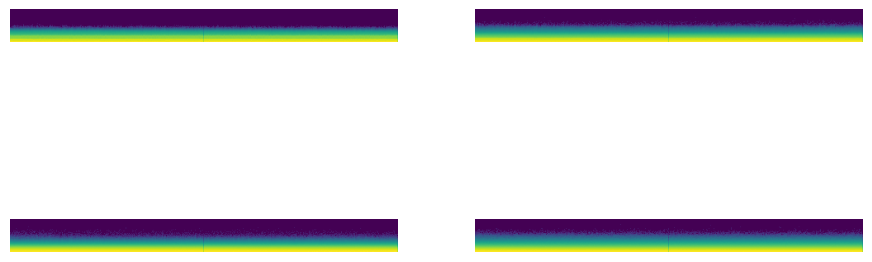

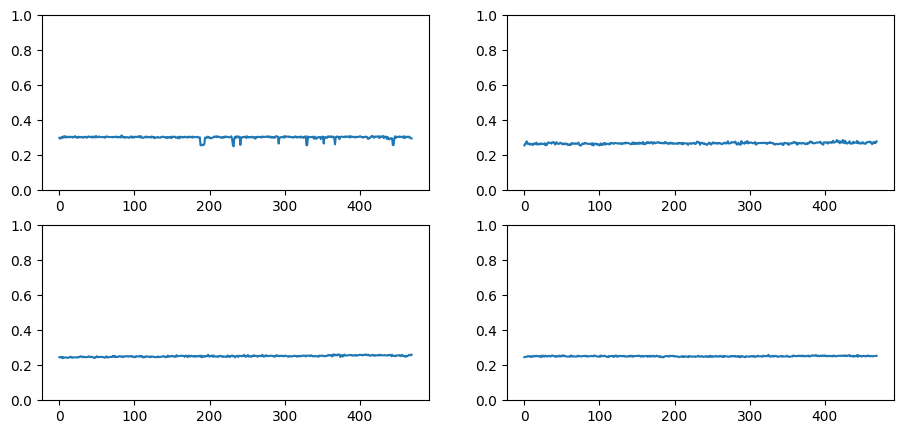

In [7]:
learn.fit(2, lr=0.05)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

In [8]:
class momSGD(SGD):
    def __init__(self, parameters, lr=0.01, wd=0.0, mom=0.9):
        super().__init__(parameters, lr, wd)
        self.mom = mom
        
    def update_weight(self):
        for p in self.parameters:
            if not hasattr(p, 'avg_grad'): p.avg_grad = torch.zeros_like(p.grad)
            p.avg_grad.lerp_(p.grad, 1 - self.mom)
            p.data -= self.lr * p.avg_grad

accuracy,loss,epoch,train
0.834,0.458,0,train
0.864,0.377,0,eval
0.885,0.309,1,train
0.878,0.337,1,eval
0.897,0.276,2,train
0.877,0.338,2,eval


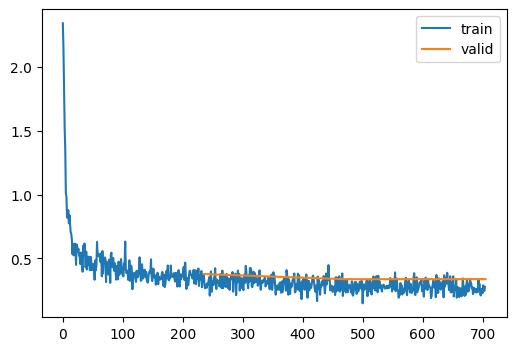

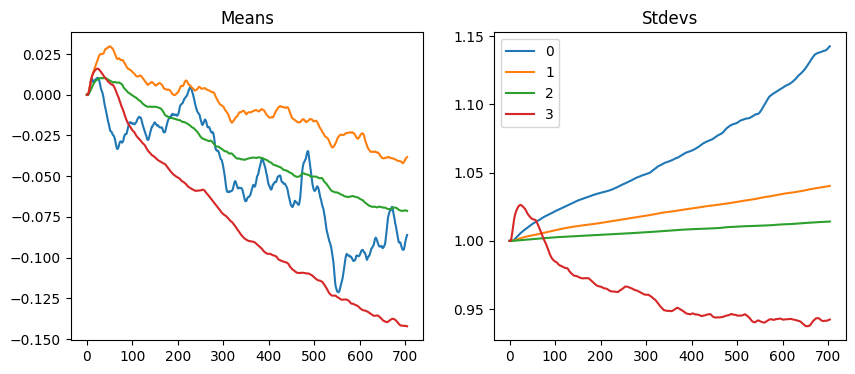

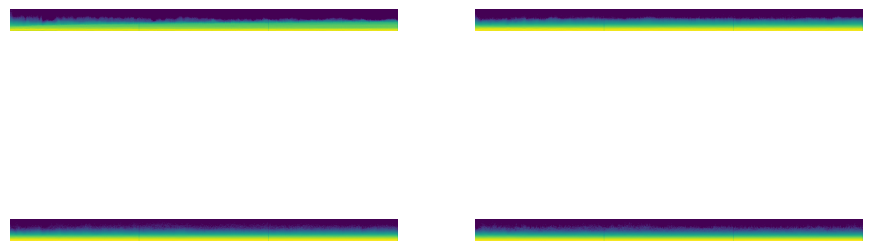

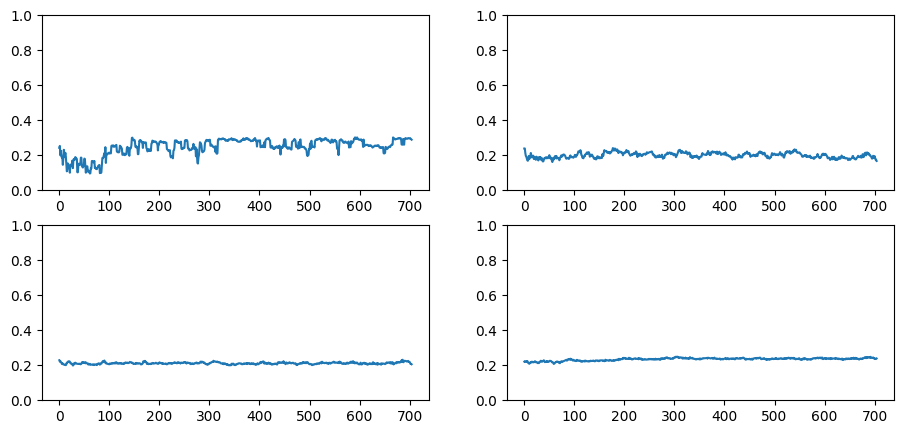

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
learn = Learner(get_model(), dls, F.cross_entropy, opt_func=momSGD, lr=1,cbs=cbs)
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

In [10]:
class rmsProp(SGD):
    def __init__(self, parameters, lr=0.01, wd=0.0, mom=0.9, sqr_mom=0.99, esp=1e-5):
        super().__init__(parameters, lr, wd)
        self.mom, self.sqr_mom, self.esp = mom, sqr_mom, esp
        
    def update_weight(self):
        for p in self.parameters:
            if not hasattr(p, 'square_grad'): p.square_grad = p.grad**2
            p.square_grad.lerp_(p.grad**2, 1 - self.sqr_mom)
            p.data -= self.lr * p.grad / (torch.sqrt(p.square_grad) + self.esp)

accuracy,loss,epoch,train
0.819,0.522,0,train
0.832,0.451,0,eval
0.880,0.329,1,train
0.851,0.409,1,eval
0.895,0.285,2,train
0.873,0.350,2,eval


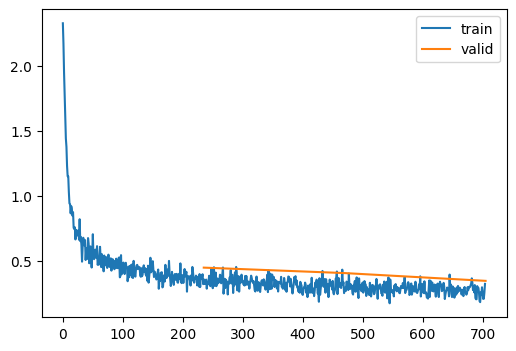

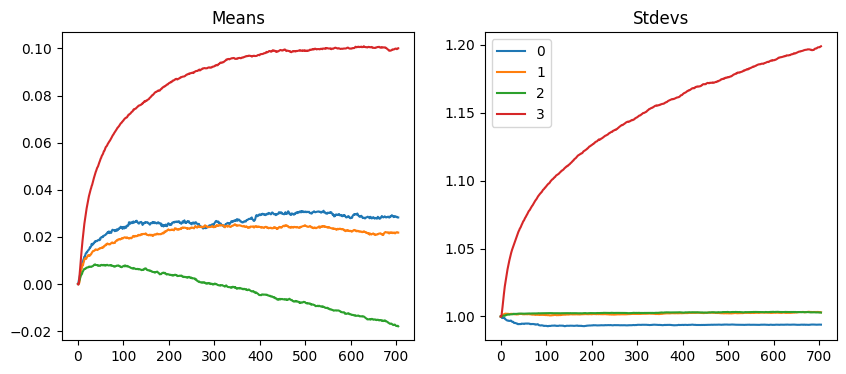

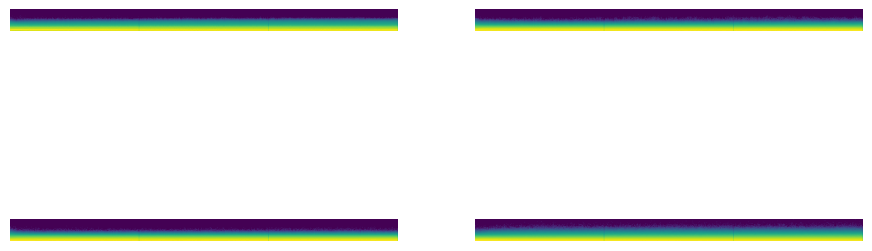

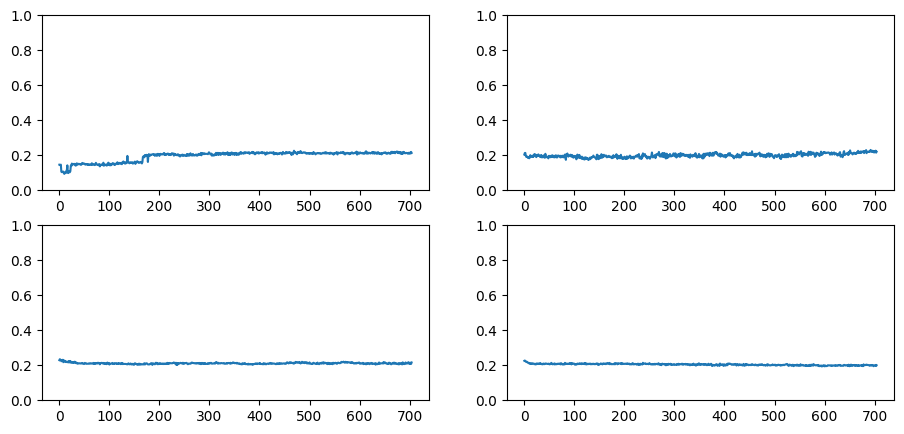

In [11]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
learn = Learner(get_model(), dls, F.cross_entropy, opt_func=rmsProp, lr=1e-3,cbs=cbs)
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

In [87]:
class Adam(SGD):
    def __init__(self, parameters, lr=0.01, wd=0.0, avg_mom=0.9, sqr_mom=0.99, esp=1e-5):
        super().__init__(parameters, lr, wd)
        self.avg_mom, self.sqr_mom, self.esp = avg_mom, sqr_mom, esp
        
    def update_weight(self):
        for p in self.parameters:
            if not hasattr(p, 'square_grad'): p.square_grad = p.grad**2
            if not hasattr(p, 'avg_grad'): p.avg_grad = torch.zeros_like(p.grad)
            p.square_grad.lerp_(p.grad**2, 1 - self.sqr_mom)
            p.avg_grad.lerp_(p.grad, 1 - self.avg_mom)
            # correct bias
            unbias_square_grad = p.square_grad / (1 - self.sqr_mom**(self.i + 1))
            unbias_avg_grad = p.avg_grad / (1 - self.avg_mom**(self.i + 1))
            # step
            p.data -= self.lr * unbias_avg_grad / (torch.sqrt(unbias_square_grad) + self.esp)

In [88]:
from miniai.learner import SingleBatchCB
import miniai

accuracy,loss,epoch,train
0.829,0.474,0,train
0.869,0.355,0,eval
0.882,0.316,1,train
0.881,0.330,1,eval
0.897,0.277,2,train
0.882,0.309,2,eval


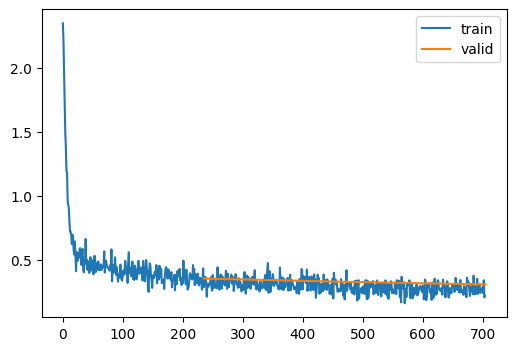

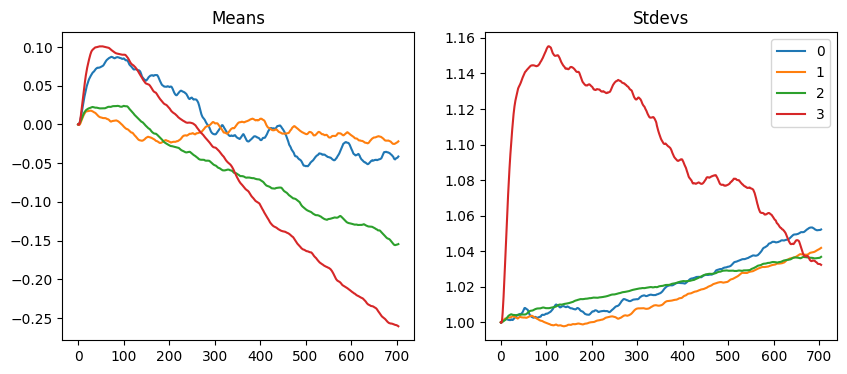

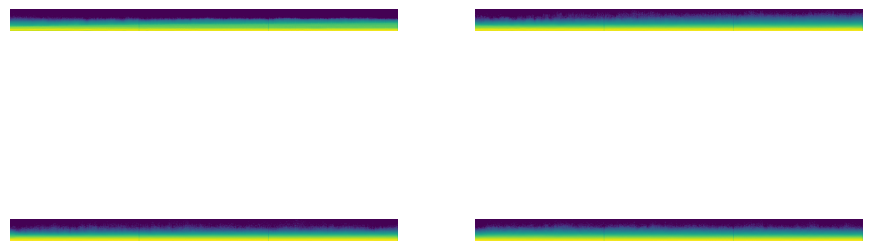

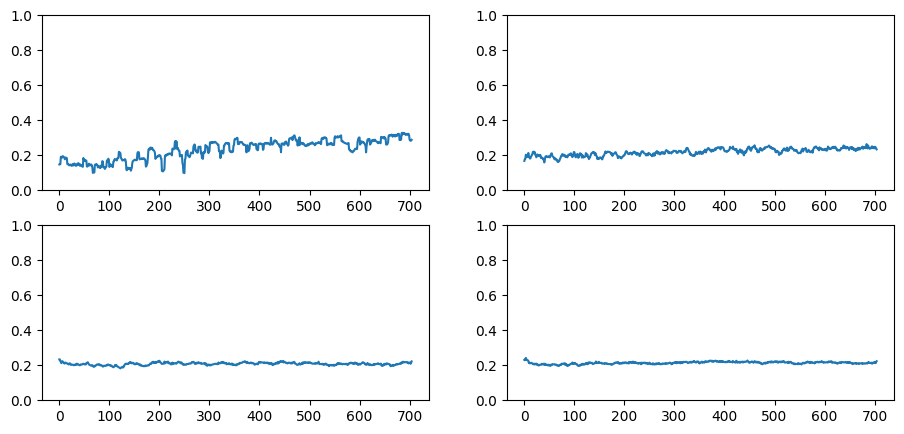

In [117]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
learn = Learner(get_model(), dls, F.cross_entropy, opt_func=Adam, lr=1e-2,cbs=cbs)
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()